## Train Base Model -- Development of a Transaction Categorization Model

This notebook aims to create the base model to categorize transactions. In this scenario, all categories will have the same importance, adjusted by the frequency.

### Tasks:
 - [X] Load training dataset.
 - [X] Create k folds for experiments.
 - [X] Generate feature vector.
 - [X] Train model.
     - [X] Adjust weights;
     - [X] Compute metrics based on folds;
     - [X] Train final model;
 - [ ] Submit model, parameters and metrics do MLflow.

## Libraries and Configurations

In [1]:
import copy

import pandas as pd
from lightgbm.sklearn import LGBMClassifier

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

from application.code.core.configurations import configs
from application.code.adapters.storage import read_dataset
from application.code.core.dataset_split_service import generate_folds, describe_datasets
from application.code.core.feature_engineering import engineer_features, standardize_labels
from application.code.core.model_training_service import train_model
from application.code.core.model_training import (clean_data,
                                                  vectorize_folds,
                                                  compute_weights,
                                                  generate_encoders,
                                                  vectorize_dataset)
from application.code.core.model_evaluation import (compute_multiclass_classification_metrics,
                                                    generate_feature_importance_report,
                                                    generate_confusion_matrix,
                                                    plot_folds_metrics)

from application.code.adapters.mlflow_adapter import log_dataframe_artifact, get_mlflow_artifact_content

sns.set_style("whitegrid")

## Constants

In [2]:
BASE_MODEL_PARAMS = {
    'objective': 'multiclass', 
    'metric': 'multi_error',
    'verbosity': -1, 
    'n_estimators': 500,
    'random_state': configs.model_training.model_seed,
    'deterministic': True
}

TARGET_COLUMN = 'grupo_estabelecimento'

CATEGORICAL_COLUMNS = ['cidade', 'estado', 'sexo', 'data',
                       'cidade_estabelecimento','pais_estabelecimento']

HIGH_CARDINALITY_CATEGORICAL_COLUMNS = [
    'cidade', 'estado', 
    'cidade_estabelecimento', 'pais_estabelecimento', 'estado_estabelecimento',
]

BINARY_COLUMNS = ['sexo',  'dia_util',
                  'cidade_diferente', 'estado_diferente', 'pais_diferente',]

NUMERIC_COLUMNS = ['idade',
                   'limite_total', 'limite_disp', 'valor', 
                   'dia_semana', 'dia_mes', 'mes',
                   'valor_relativo_total', 'valor_relativo_disponivel',
                  ]

COLUMNS_SELECTION  = (
    HIGH_CARDINALITY_CATEGORICAL_COLUMNS +
    BINARY_COLUMNS + 
    NUMERIC_COLUMNS
)

EXPERIMENT_RUN_NAME = 'Base Model'

## MLflow Settings

In [3]:
mlflow.set_tracking_uri(configs.mlflow.uri)
mlflow.set_experiment(configs.mlflow.experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/1', experiment_id='1', lifecycle_stage='active', name='transaction_category', tags={}>

## Load Dataset

The `training` dataset is loaded to create the model perform experiments.

In [4]:
df = read_dataset(base_path=configs.datasets.base_path, stage='raw', file_name='train')

display(HTML('<h4>Dataset</h4>'))
print(f'Records: {len(df)}')

Records: 3944


To create the model and perform experiments, only the `training` dataset will be used. The evaluation will be performed by creating some time-oriented `validation` datasets using the same methodology used to create the `test` dataset.

3 sets of `training` and `validation` sets will be created, each of them representing a fold. At the end, it will be possible to have an efficacy measurement with a variance notion.
It is important to use `validation` set avoid using the `test` several times. Ideally, it should be used only once, for the final assessment.

In [5]:
folds = generate_folds(df,
                       n_folds=configs.model_training.folds,
                       min_validation_size=configs.model_training.min_validation_size,
                       seed=configs.model_training.data_seed)

Summarize and validate folds (`training` and `validation` sets should not share records).

In [6]:
for ix, (train_df, valid_df) in enumerate(folds):

    display(HTML(f'<strong>Fold <code>{ix}</code></strong>'))
    describe_datasets(train_df, valid_df, TARGET_COLUMN)
    print()

    train_periods = set(train_df["period"].tolist())
    valid_periods = set(valid_df["period"].tolist())

    assert len(train_periods & valid_periods) == 0, \
    'Training and Validation share dates.'

 - Split Period: 2019-12-31
 - Training:
	 - Size: 3533
	 - Days: 274
	 - Labels: 21
 - Assessment:
	 - Size: 27
	 - Days: 27
	 - Labels: 18
 - Assessment Relative Size: 10.42%



 - Split Period: 2019-12-03
 - Training:
	 - Size: 3108
	 - Days: 246
	 - Labels: 21
 - Assessment:
	 - Size: 28
	 - Days: 28
	 - Labels: 19
 - Assessment Relative Size: 12.03%



 - Split Period: 2019-11-06
 - Training:
	 - Size: 2679
	 - Days: 219
	 - Labels: 21
 - Assessment:
	 - Size: 27
	 - Days: 27
	 - Labels: 18
 - Assessment Relative Size: 13.80%



 - Split Period: 2019-10-04
 - Training:
	 - Size: 2243
	 - Days: 186
	 - Labels: 20
 - Assessment:
	 - Size: 33
	 - Days: 33
	 - Labels: 17
 - Assessment Relative Size: 16.27%



 - Split Period: 2019-08-27
 - Training:
	 - Size: 1826
	 - Days: 148
	 - Labels: 20
 - Assessment:
	 - Size: 38
	 - Days: 38
	 - Labels: 18
 - Assessment Relative Size: 18.59%



## Dataset Preprocessing and Feature Vectorization

Vectorization of each fold based on the following strategy:
 - For each fold:
   - Perform basic cleaning:
       - Remove duplicated records.
       - Format column names.
       - Cast column types.
       - Standardize string values.
   - Create new features based on the orignal features.
   - Use the `training` set to create encoders (label and categorical columns);
       - `LabelEncoder` represents target labels into numbers.
       - `CountEncoder` represents high cardinality categorical data into numbers -- This method deals with missing values and avoid the need to create multiple columns to represent the values, reducing the sparsity of the feature vector.
    - Transform binary columns into `0` or `1`
   
The value are not scaled due to the use of a tree-based algorithm (LightGBM), which is not sensitive to feature scale -- [besides some evidences possibilities](https://arxiv.org/pdf/1611.04561.pdf).


In [7]:
vectorized_folds = vectorize_folds(folds,
                                   columns_selection=COLUMNS_SELECTION,
                                   categorical_columns=CATEGORICAL_COLUMNS,
                                   high_cardinality_categorical_columns=HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
                                   binary_columns=BINARY_COLUMNS,
                                   target_column=TARGET_COLUMN,
                                  )

## Model Training on Folds

As stated before, LightGBM will be used as algorithm to learn a model. It was chosen because:
 - Is based on trees and does not require scalling features.
 - Has good results on Industry and at Machine Learning competitions.
 - Is able to deal with missing values.
 - Has good efficiency and support for high volume of data (using GPU or distributed computing). 
 - Provides an API compatible with SKlearn.
 - Has a good [documentation](https://lightgbm.readthedocs.io/en/v3.3.2/) and community content (e.g., blogs and forums).
 - Is supported by different ML tools (e.g., Optuna, ONNX, Dask, and Spark)

### Training and Evaluation on Folds

For each fold (a pair of `training` and `validation` sets), the steps performed are:
 - Compute *class weights* to make all records have the same importance for the model -- which is a strategy to fix the unbalancing problem without the need to generate synthetic data.
 - Train the model.
 - Make predictions based on the validation data.
 - Compute evaluation metrics based on validation labels.
 - Record resources to analyze.

In [8]:
%%time

model_params = copy.deepcopy(BASE_MODEL_PARAMS)

iterations_tracking = []
resources = []

for ix, ((train_X, train_y), (valid_X, valid_y), labels) in enumerate(vectorized_folds):

    class_weights = compute_weights(train_y)

    model_params.update({'class_weight': class_weights,
                         'num_class': len(set(train_y))})

    model = LGBMClassifier(**model_params)
    model.fit(train_X, train_y)

    preds = model.predict(valid_X)
    eval_metrics = compute_multiclass_classification_metrics(valid_y, 
                                                             preds.round())

    iteration_tracking = {**{'Fold': ix,
                             'training_size': train_X.shape[0],
                             'validation_size': valid_X.shape[0],},
                          **eval_metrics}
    iterations_tracking.append(iteration_tracking)    
    
    resources.append({'model': model,
                      'pred': preds,
                      'y': valid_y,
                      'labels': labels
                     })

CPU times: user 3min 42s, sys: 1.89 s, total: 3min 44s
Wall time: 30 s


### Folds Metrics

Considering the unbalance of the labels, it is important to consider metrics that are not sensitive to it. For that purpose, `Precision`, `Recall`, and `F1` are good alternatives to provide information about each class. `Accuracy` might not be the best to be affected by the unbalance -- but there are `balanced` versions of it that could be used.


The selected metrics are computed with three [average strategies available at Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score):
 - `micro`: Calculate metrics globally by counting the total true positives, false negatives and false positives.
 - `macro`: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
 - `weighted`: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

,Fold,training_size,validation_size,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,weighted_precision,weighted_recall,weighted_f1
0,0,3531,411,0.168378,0.146911,0.152202,0.420925,0.420925,0.420925,0.406771,0.420925,0.408400
1,1,3106,425,0.340539,0.297991,0.300029,0.432941,0.432941,0.432941,0.474674,0.432941,0.426542
2,2,2677,429,0.295680,0.308083,0.291910,0.396270,0.396270,0.396270,0.394470,0.396270,0.393227
3,3,2241,436,0.262015,0.260289,0.251683,0.440367,0.440367,0.440367,0.426525,0.440367,0.422789
4,4,1824,417,0.267717,0.271522,0.245963,0.489209,0.489209,0.489209,0.480212,0.489209,0.473113


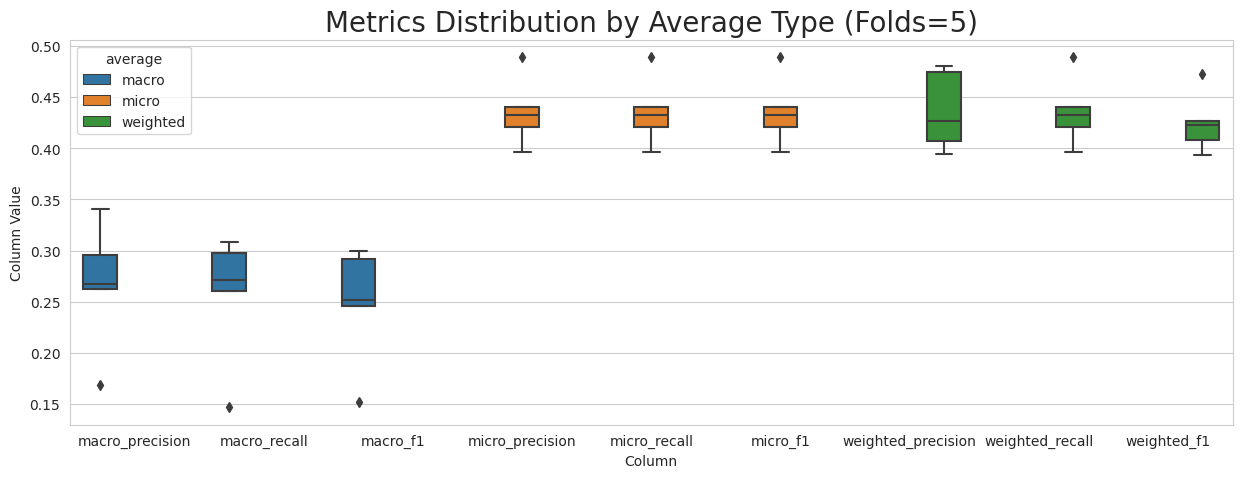

,mean,std
macro_precision,0.266866,0.063210
macro_recall,0.256959,0.064481
macro_f1,0.248358,0.058799
micro_precision,0.435942,0.034151
micro_recall,0.435942,0.034151
micro_f1,0.435942,0.034151
weighted_precision,0.436530,0.039108
weighted_recall,0.435942,0.034151
weighted_f1,0.424814,0.030029


In [9]:
folds_evaluation_df = pd.DataFrame(iterations_tracking)

display(HTML('<h4>Individual Folds Results</h4>'))
display(folds_evaluation_df)

plot_folds_metrics(folds_evaluation_df)

display(HTML('<strong>Summarized Fold Metrics</strong>'))
summarized_validation_metrics_df = (
    folds_evaluation_df
    .drop(columns=['Fold', 'training_size', 'validation_size'])
    .agg(['mean', 'std'])
    .T
)
display(summarized_validation_metrics_df)

It is possible to observe that:
 - `macro` average penalizes the model due to the absence or low number of records related to most of the classes and the dataset umbalance.
 - `micro` average shows that, in average, the model predicts almost 45% of the correct labels.
 - `weighted` average shows a slightly improvement over the `micro` average, probably because the model is correctly predicting the most frequent classes and the weighting is increasing the metric.
 
For this scenario, `micro` average seems to be relevant for the overwall model performance, while the `weighted` average computes the performance considering the most frequent classes.

### Confusion Matrix

Select the top 10 labels (based on frequency) to provide a better view of the data.

In [10]:
top_labels_df = (df
 .pipe(clean_data, ['grupo_estabelecimento'])  
 [['grupo_estabelecimento']]
 .assign(records=1)
 .groupby('grupo_estabelecimento')
 .sum()
 .reset_index()
 .sort_values(by='records', ascending=False)
 .head(10)
)

top_labels = top_labels_df['grupo_estabelecimento'].tolist()

Next, the confusion matrix is generated and the results are presented for the top 10 labels.

In [11]:
selected_fold = 0
resource = resources[selected_fold]
display(HTML(f'<strong>Confusion Matrix for Top 10 Categories based on Model for Fold <code>{selected_fold}</code></strong>'))
confusion_matrix_df = generate_confusion_matrix(resource['y'], 
                                                resource['pred'], 
                                                resource['labels'])

(
    confusion_matrix_df
    .loc[top_labels, top_labels]    
)

,serviço,restaurante,varejo,supermercados,vestuário,farmácias,posto de gás,compra online,artigos eletro,loja de departamento
serviço,100,11,7,7,1,3,0,1,0,1
restaurante,12,24,5,16,4,2,1,1,0,0
varejo,12,9,13,10,3,1,0,5,1,0
supermercados,8,9,13,14,3,1,0,1,1,0
vestuário,6,2,3,1,2,1,1,1,0,1
farmácias,5,2,4,2,0,1,0,0,0,1
posto de gás,1,5,1,4,0,1,5,0,0,0
compra online,1,1,2,3,1,0,0,9,1,1
artigos eletro,2,1,0,0,2,0,0,1,4,0
loja de departamento,3,1,2,1,0,0,0,0,0,1


Some interesting points based on the confusion matrix:
 - `serviço` is the most popular category and has the best number of right answers. It "loses" and "gains" predictions from the next top three categories (`restaurante`, `supermercados`, and `varejo`).
 - `restaurante` and `supermercados` seems be similar, based on the false positives exchanged.
 - `vestuario` has a low number of cases, which seems to justify the model's low eficacy. 

## Main Model Training

This section creates the final model, using all the `training` set. The final evaluation will be performed in another notebook, to avoid reusing the `test` set.

In [12]:
%%time

clean_df = (
    df
    .pipe(clean_data, CATEGORICAL_COLUMNS + [TARGET_COLUMN])
    .pipe(engineer_features)
)

labels = clean_df[TARGET_COLUMN].unique().tolist()

label_encoder, categorical_encoder = generate_encoders(
    clean_df[COLUMNS_SELECTION],
    labels,
    HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
)

X_training, y_training = vectorize_dataset(df,
                                           label_encoder, 
                                           categorical_encoder,
                                           columns_selection=COLUMNS_SELECTION,
                                           categorical_columns=CATEGORICAL_COLUMNS,
                                           binary_columns=BINARY_COLUMNS,
                                           target_column=TARGET_COLUMN,
                                          )

model_params = copy.deepcopy(BASE_MODEL_PARAMS)

extra_artifacts = [
    (confusion_matrix_df, 'validation folds', 'confusion matrix'),
    (summarized_validation_metrics_df, 'validation folds', 'metrics')
]

mlflow_run = train_model(
    algorithm_class=LGBMClassifier,
    model_params=model_params,
    X_training=X_training,
    y_training=y_training,
    experiment_run_name=EXPERIMENT_RUN_NAME,
    extra_artifacts=extra_artifacts,
    features_names=COLUMNS_SELECTION,
)

CPU times: user 22.4 s, sys: 192 ms, total: 22.6 s
Wall time: 3.41 s


### Model Artifacts

In [13]:
main_model_artifacts = get_mlflow_artifact_content(mlflow_run.info.run_id, 'main model')

for artifact_name, content in main_model_artifacts.items():
    display(HTML(f'<h4>{artifact_name.capitalize()}</h4>'))
    display(HTML(main_model_artifacts[artifact_name]))

,feature,absolute_importance,relative_importance
13,valor,6714,17.86%
12,limite_disp,4655,12.38%
17,valor_relativo_total,4392,11.68%
18,valor_relativo_disponivel,4341,11.55%
15,dia_mes,3876,10.31%
2,cidade_estabelecimento,2770,7.37%
10,idade,2654,7.06%
16,mes,2415,6.42%
11,limite_total,2124,5.65%
14,dia_semana,1616,4.30%


,metric,value
0,macro_precision,0.109722
1,macro_recall,0.066790
2,macro_f1,0.062518
3,micro_precision,0.251142
4,micro_recall,0.251142
5,micro_f1,0.251142
6,weighted_precision,0.259810
7,weighted_recall,0.251142
8,weighted_f1,0.233822


,class,weight
0,0,31.285714
1,1,187.714286
2,2,1.975940
3,3,15.642857
4,4,6.257143
5,5,1.321932
6,6,1.137662
7,7,11.732143
8,8,8.938776
9,9,37.542857


## Concluding Remarks
 - Effectiveness:
     - The F1 performance on the `validation folds` are low (about 45% of F1, based on micro average). The main reason might be related to the unbalance and low frequency of some categories and dataset unbalance.
     - The most recent fold has the second worst performance. That is curious because it has the highest ammount of training data.
     - The best performance was on the last fold, with the least ammount of data. That might be an indicative that it is important to keep only recent data with respect to the prediction data. It can be achieved by restrincting the training window of data or reducing the weights of old data.
 - Features:
     - Features based on `valor` and `limite` are the most important for the algorithm.
     - From the new feature created, `dia_mes` and `mes` were the most relevant. That is interesting for the final assessment because the dataset contains only 1 year of data. The test set will not have data with known months at the training set.
     - There are 7 features with less than 1% of relative importance. 
 
 - Overwall:
     - As there is a limited number of records related to the less frequent categories, an alternative approach would be grouping all of them into a `others` group. 
 
 
Some alternative approaches could be experimented:
 - Perform hyperparameters tuning using [Optuna](https://optuna.org/).
 - Make older data less relevant by decreasing the weights of each record based on time.
 - Use [alternative encoders](https://contrib.scikit-learn.org/category_encoders) for high cardinality categories. `Catboost` and `LeaveOneOut` are some of the notable candidates.
 - Apply alternative algorithms to improve results.
 - Perform adversarial validation to check drift between `training` and `assessment` datasets.
 - Use SHAP to compute feature importance in a more reliable way.